# Вводная информация об объекте исследования
Вы будете работать с данными, которые собираются с самосвалов, перевозящих породу (например, уголь) на карьере. На самосвалах стоят датчики, которые собирают множество различной информации (скорость, высота, расход топлива и тд). Данные с каждого датчика приходят вместе с временной меткой, идентификатором самосвала и его местоположением (координатами) в момент получения значения с датчика.

Сам по себе карьер состоит из пунктов погрузки (откуда вывозят породу), пунктов разгрузки (куда её отвозят) и маршрутов между ними. На картинке показан пример исходных данных координат самосвалов (синие точки) и примерных дорог на карьере (фиолетовые). Пункты погрузки и разгрузки на картинке не указаны.

Одним рейсом самосвала называется его движение от пункта погрузки до пункта разгрузки и обратно до пункта погрузки.

![](https://drive.google.com/uc?export=view&id=1QLscdUpjOGU8m9WvN8ulKdC9YBWJyKw4)

# Часть 1. SQL

Дана упрощенная схема базы данных:

![](https://drive.google.com/uc?export=view&id=1eZVg0OMLNh3Zn4Ss00oNw6KtcMYMTtdZ)

**telemetry** - таблица с телеметрией карьерных самосвалов следующего формата:

| id | objectid | time | sensorid | value | lat | lon | speed|
| :-: |:-: |:-: |:-: |:-: |:-: |:-: |:-: |
| 42 | 123 | 01.01.2024 | 21:00:54 | 35 | 85,694 | 51.384 | 41.857 | 15.81 |

где
* id - номер записи в таблице
* objectid - идентификатор самосвала
* time - момент времени
* sensorid - идентификатор датчика
* value - значение, которое передал датчик
* lat, lon - координаты
* speed - текущая скорость самосвала

**objects** - таблица, в которой хранится информация о самосвалах:

| id | modelname | enterprise_id | created_at |
| :-: |:-: |:-: |:-: |
| 123 | БелАЗ-75131 | 4 | 01.01.2024 | 00:00:00 |

где
* id - идентификатор самосвала
* modelname - модель самосвала
* enterprise_id - идентификатор предприятия
* created_at - временная метка создания записи

**sensors** - таблица с описанием датчиков:

| id | name | tag | min_value | max_value |
| :-: |:-: |:-: |:-: | :-: |
| 35 | Вес | weight | 0 | 180 |

где
* id - идентификатор датчика
* name - наименование датчика
* tag - тег датчика
* min_value - минимальное допустимое значение датчика
* max_value - максимальное допустимое значение датчика


## Задание 1
Необходимо написать запрос, который для каждого самосвала модели “БелАЗ-75320” на предприятии с id = 6 выведет процент количества записей телеметрии, когда значение тега высоты (height) находилось в допустимых пределах, относительно всех записей по данному датчику за последние сутки.

In [ ]:
SELECT
    o.id AS object_id,
    o.modelname AS model_name,
    COUNT(CASE WHEN t.sensorid = s.id AND s.tag = 'height' AND t.value BETWEEN s.min_value AND s.max_value THEN 1 END) * 100.0 / COUNT(*) AS percentage_within_limits
FROM
    telemetry t
JOIN
    objects o ON t.objectid = o.id
JOIN
    sensors s ON t.sensorid = s.id
WHERE
    o.modelname = 'БелАЗ-75320' AND
    o.enterprise_id = 6 AND
    t.time >= DATE_SUB(NOW(), INTERVAL 1 DAY)
GROUP BY
    o.id, o.modelname;

## Задание 2
Необходимо написать запрос, для вывода уникальных значений по датчику satenum (количество доступных спутников связи) для каждого самосвала с идентификатором из списка [34, 42, 99] за последние двое суток.

In [ ]:
SELECT
    objectid,
    DISTINCT value AS unique_satenum
FROM
    telemetry
WHERE
    sensorid = (SELECT id FROM sensors WHERE name = 'satenum') AND
    objectid IN (34, 42, 99) AND
    time >= DATE_SUB(NOW(), INTERVAL 2 DAY);

## Задание 3
В таблицу с телеметрией собираются данные с датчика уровня топлива в процентах (тег fuel_tank_level). В данной задаче будем считать, что самосвалы в течение последнего часа ездят непрерывно, а значит и уровень топлива постепенно снижается. Необходимо написать запрос, который для каждого самосвала модели “БелАЗ-75131” вернет 1, если был зафиксирован хоть один случай, когда между двумя последовательными временными точками изменение уровня топлива было более 5%, или вывести 0, если подобной аномалии не было.

In [ ]:
SELECT
    CASE WHEN EXISTS (
        SELECT 1
        FROM (
            SELECT
                *,
                LAG(value) OVER (PARTITION BY objectid ORDER BY time) AS prev_fuel_level
            FROM
                telemetry t
            JOIN
                objects o ON t.objectid = o.id
            JOIN
                sensors s ON t.sensorid = s.id
            WHERE
                o.modelname = 'БелАЗ-75131' AND
                s.tag = 'fuel_tank_level'
        ) AS sub
        WHERE
            ABS(value - prev_fuel_level) > 5
    ) THEN 1 ELSE 0 END AS fuel_anomaly_detected
FROM
    telemetry t
JOIN
    objects o ON t.objectid = o.id
JOIN
    sensors s ON t.sensorid = s.id
WHERE
    o.modelname = 'БелАЗ-75131' AND
    s.tag = 'fuel_tank_level';

# Часть 2. Python

## Данные:

**telemetry.parquet** - данные телеметрии
* objectid - идентификатор самосвала
* tripid - идентификатор рейса
* driverid - идентификатор водителя
* time - время получения данных с датчиков
* lat, lon - широта и долгота самосвала в текущий момент времени
* x, y, - координаты самосвала на плоскости (https://en.wikipedia.org/wiki/Universal_Transverse_Mercator_coordinate_system)
* speed - данные с датчика скорости
* height - высота в текущий момент времени
* engine_speed - обороты двигателя
* fuel_cons - мгновенный расход топлива
* fuel_tank_level - уровень топлива в баке (в процентах)
* weight_dynamic - мгновенное значение веса с датчика (растет, пока самосвал грузит, колеблется вокруг константы, когда едет загруженный и обнуляется при разгрузке и движении без груза обратно на погрузку)
* weight - значение веса груза, который перевез самосвал за текущий рейс (константа для каждого рейса. Даже на той части рейса, где самосвал ехал пустым обратно на погрузку значение этого параметра будет равно весу груза)
* DQ_vertical_bump - вертикальное ускорения
* accelerator_position - позиция педали газа
* w_fl - ?

Пропуски в колонках fuel_tank_level и weight_dynamic обусловлены тем, что эти датчики собираются с меньшей дискретностью (условно, раз в 10 секунд, а не раз в секунду). При необходимости, можно восполнить Nan значения последним определенным значением (т.е. [1, 2, nan, 3, nan, 4, ...] -> [1, 2, 2, 3, 3, 4, ...])

**weather_hourly.parquet** - почасовая погода на карьере. Значения колонок понятны из их названий.

## Задание 1

* Отобразить на графике все местоположения самосвалов из исходных данных (предварительно убрав очевидные выбросы по координатам) = карта карьера (пока некорректная из-за ещё некоторых проблем с координатами)
* Обнаружить самосвал(ы), для которых всё ещё есть проблемы с координатами (обозначить их идентификаторы)
* Понять, по какому параметру можно избавиться от этих выбросов по координатам, и сделать чистку
* Нарисовать корректную карту карьера (если удалость определить, как сделать чистку)
* При необходимости, произвести чистку по другим колонкам (препроцессинг для дальнейшего обучения модели)
* Предположить, что обозначают значения колонки w_fl (путем анализа имеющихся данных) - ответ написать в текстовом поле и обосновать

In [17]:
import pandas as pd

file_path = 'C:/Users/User/Downloads/telemetry.parquet'

data = pd.read_parquet(file_path)

data.head()

,objectid,time,lat,lon,speed,height,fuel_cons,engine_speed,hdop,DQ_vertical_bump,accelerator_position,fuel_tank_level,weight_dynamic,tripid,weight,driverid,w_fl,x,y
0,1121,2023-11-08 05:31:31.309000+07:00,63.328824,83.727988,3.00394,195.7,390.00,NaN,99.99,0,0,60.0,216.0,1003671.0,215.0,2891.0,1,636592.202274,7.025133e+06
1,1125,2023-11-08 03:21:39+07:00,63.334962,83.751046,0.00000,280.0,0.00,0.000,8.00,0,0,NaN,NaN,1003657.0,216.0,2887.0,0,637716.857273,7.025866e+06
2,1124,2023-11-08 19:20:55+07:00,63.343592,83.739678,4.20000,228.0,66.85,778.000,5.00,0,0,NaN,NaN,1003798.0,217.0,2875.0,0,637106.943106,7.026803e+06
3,1124,2023-11-08 14:16:39+07:00,63.343290,83.751773,16.80000,278.0,2.45,743.375,6.00,0,0,NaN,NaN,1003749.0,209.0,2875.0,0,637713.403209,7.026795e+06
4,1121,2023-11-08 11:09:49.347000+07:00,63.331924,83.765388,0.00000,70.9,17.00,NaN,99.99,0,0,38.0,0.0,1003728.0,204.0,2894.0,0,638449.084136,7.025559e+06


In [100]:
file_path_weather = 'C:/Users/User/Downloads/weather_hourly.parquet'

data_weather = pd.read_parquet(file_path_weather)

data_weather.head()

,time,precipIntensity,precipProbability,temperature,apparentTemperature,dewPoint,humidity,pressure,windSpeed,windGust,windBearing,cloudCover,visibility,precipType,rain,snow,no_weather_info
0,2023-11-07 20:00:00+00:00,0.0,0.0,-13.27,-20.02,-17.59,67.0,1027.0,3.48,8.91,60.0,100.0,10000.0,clouds,0,0,1
1,2023-11-08 06:00:00+00:00,0.0,0.0,-9.27,-15.79,-16.07,54.0,1020.0,4.13,8.20,71.0,100.0,10000.0,clouds,0,0,1
2,2023-11-07 18:00:00+00:00,0.0,0.0,-13.27,-20.10,-17.59,67.0,1028.0,3.55,8.92,62.0,95.0,10000.0,clouds,0,0,1
3,2023-11-07 16:00:00+00:00,0.0,0.0,-13.27,-19.67,-17.44,68.0,1030.0,3.18,7.71,61.0,94.0,10000.0,clouds,0,0,1
4,2023-11-07 11:00:00+00:00,0.0,0.0,-10.27,-16.63,-14.37,69.0,1033.0,3.72,9.60,64.0,65.0,10000.0,clouds,0,0,1


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426322 entries, 0 to 426321
Data columns (total 19 columns):
 #   Column                Non-Null Count   Dtype                                
---  ------                --------------   -----                                
 0   objectid              426322 non-null  int64                                
 1   time                  426322 non-null  datetime64[ns, pytz.FixedOffset(420)]
 2   lat                   426322 non-null  float64                              
 3   lon                   426322 non-null  float64                              
 4   speed                 426322 non-null  float64                              
 5   height                426322 non-null  float64                              
 6   fuel_cons             426322 non-null  float64                              
 7   engine_speed          259203 non-null  float64                              
 8   hdop                  426322 non-null  float64                  

In [5]:
min_lat = data['lat'].min()
max_lat = data['lat'].max()
min_lon = data['lon'].min()
max_lon = data['lon'].max()
print(min_lat, max_lat, min_lon, max_lon)

0.0 63.3505441057382 0.0 83.78928779965088


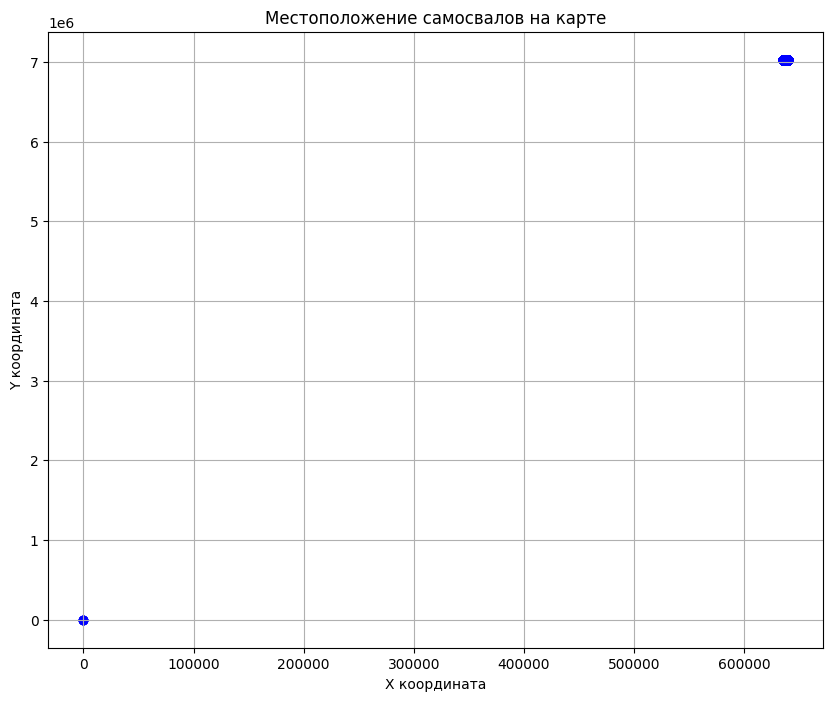

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))

plt.scatter(data['x'], data['y'], marker='o', color='blue', alpha=0.5)

plt.xlabel('X координата')
plt.ylabel('Y координата')
plt.title('Местоположение самосвалов на карте')

plt.grid(True)
plt.show()
#Замечены выбросы

In [129]:
data_cleaned = data[data['x'] >= 100000]

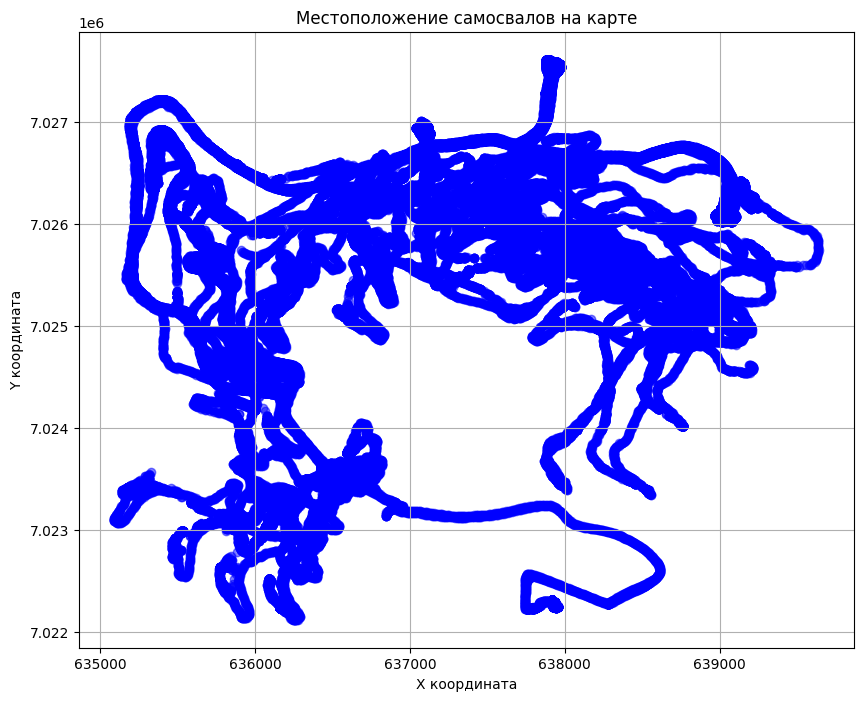

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))

plt.scatter(data_cleaned['x'], data_cleaned['y'], marker='o', color='blue', alpha=0.5)

plt.xlabel('X координата')
plt.ylabel('Y координата')
plt.title('Местоположение самосвалов на карте')

plt.grid(True)
plt.show()

In [13]:
data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 426312 entries, 0 to 426321
Data columns (total 19 columns):
 #   Column                Non-Null Count   Dtype                                
---  ------                --------------   -----                                
 0   objectid              426312 non-null  int64                                
 1   time                  426312 non-null  datetime64[ns, pytz.FixedOffset(420)]
 2   lat                   426312 non-null  float64                              
 3   lon                   426312 non-null  float64                              
 4   speed                 426312 non-null  float64                              
 5   height                426312 non-null  float64                              
 6   fuel_cons             426312 non-null  float64                              
 7   engine_speed          259203 non-null  float64                              
 8   hdop                  426312 non-null  float64                  

In [130]:
data_cleaned['fuel_tank_level'] = data_cleaned['fuel_tank_level'].fillna(method='ffill')
data_cleaned['weight_dynamic'] = data_cleaned['weight_dynamic'].fillna(method='ffill')

C:\Users\User\AppData\Local\Temp\ipykernel_2240\1155357681.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cleaned['fuel_tank_level'] = data_cleaned['fuel_tank_level'].fillna(method='ffill')
C:\Users\User\AppData\Local\Temp\ipykernel_2240\1155357681.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cleaned['weight_dynamic'] = data_cleaned['weight_dynamic'].fillna(method='ffill')


In [51]:
data_cleaned.info()
#У столбцов tripid   weight  driverid  также есть пропуски, заполню их значениями из самых часто встречающихся

<class 'pandas.core.frame.DataFrame'>
Int64Index: 426312 entries, 0 to 426321
Data columns (total 19 columns):
 #   Column                Non-Null Count   Dtype                                
---  ------                --------------   -----                                
 0   objectid              426312 non-null  int64                                
 1   time                  426312 non-null  datetime64[ns, pytz.FixedOffset(420)]
 2   lat                   426312 non-null  float64                              
 3   lon                   426312 non-null  float64                              
 4   speed                 426312 non-null  float64                              
 5   height                426312 non-null  float64                              
 6   fuel_cons             426312 non-null  float64                              
 7   engine_speed          259203 non-null  float64                              
 8   hdop                  426312 non-null  float64                  

In [131]:
import numpy as np

top_tripid_values = data_cleaned['tripid'].value_counts().index[:3]
top_weight_values = data_cleaned['weight'].value_counts().index[:3]
top_driverid_values = data_cleaned['driverid'].value_counts().index[:3]

data_cleaned['tripid'] = data_cleaned['tripid'].fillna(np.random.choice(top_tripid_values))
data_cleaned['weight'] = data_cleaned['weight'].fillna(np.random.choice(top_weight_values))
data_cleaned['driverid'] = data_cleaned['driverid'].fillna(np.random.choice(top_driverid_values))

C:\Users\User\AppData\Local\Temp\ipykernel_2240\2158026661.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cleaned['tripid'] = data_cleaned['tripid'].fillna(np.random.choice(top_tripid_values))
C:\Users\User\AppData\Local\Temp\ipykernel_2240\2158026661.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cleaned['weight'] = data_cleaned['weight'].fillna(np.random.choice(top_weight_values))
C:\Users\User\AppData\Local\Temp\ipykernel_2240\2158026661.py:9: SettingWithCopyWarning: 
A value is tryin

In [53]:
data_cleaned['engine_speed'].mean()

1099.3315089910225

In [28]:
data_cleaned['engine_speed'].max()

1874.0

In [29]:
data_cleaned['engine_speed'].min()

0.0

In [30]:
import pandas as pd

bins = range(int(data_cleaned['engine_speed'].min()), int(data_cleaned['engine_speed'].max()) + 101, 100)

engine_speed_groups = pd.cut(data_cleaned['engine_speed'], bins=bins).value_counts().sort_index()
engine_speed_groups

(0, 100]            0
(100, 200]          0
(200, 300]          0
(300, 400]          0
(400, 500]          0
(500, 600]          0
(600, 700]      10801
(700, 800]      18265
(800, 900]      13772
(900, 1000]     13006
(1000, 1100]    44764
(1100, 1200]    63275
(1200, 1300]    25092
(1300, 1400]    19343
(1400, 1500]    12545
(1500, 1600]     9220
(1600, 1700]     5407
(1700, 1800]     3992
(1800, 1900]     7580
Name: engine_speed, dtype: int64

In [132]:
#Самое большое количество значений от 1000 до 1300, решил заполнить пропущенные значения в этом с толбце рандомно в этом интервал
data_cleaned['engine_speed'] = data_cleaned['engine_speed'].fillna(np.random.randint(1000, 1301))

C:\Users\User\AppData\Local\Temp\ipykernel_2240\3106122055.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cleaned['engine_speed'] = data_cleaned['engine_speed'].fillna(np.random.randint(1000, 1301))


C:\Users\User\AppData\Local\Temp\ipykernel_2240\4076544215.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = data_cleaned.corr()
C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


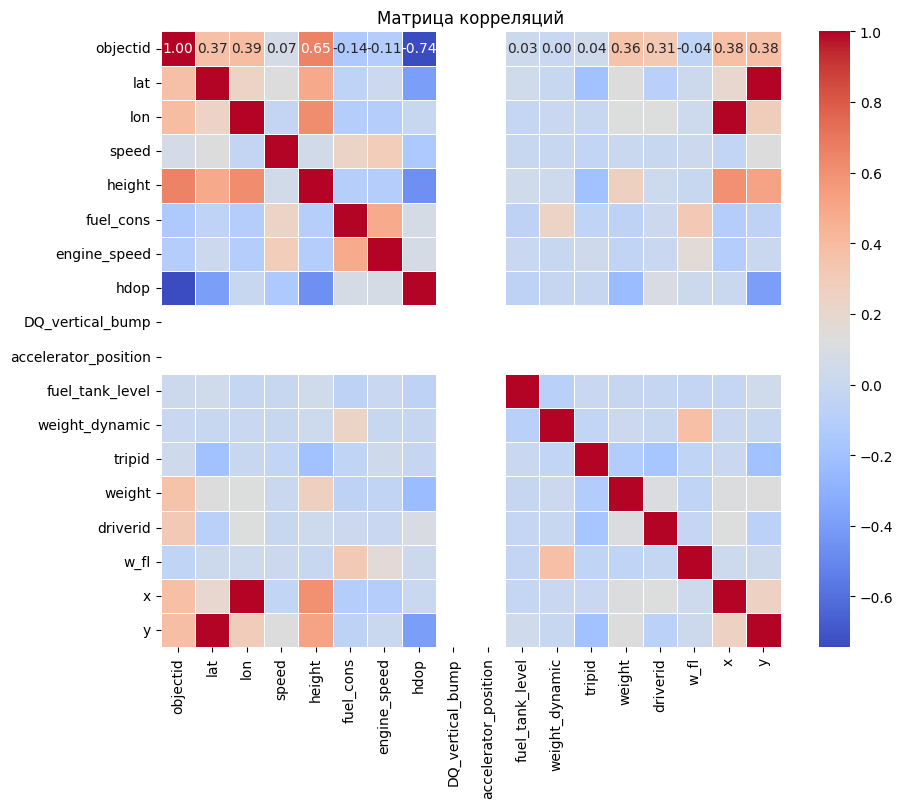

In [85]:
import seaborn as sns
import matplotlib.pyplot as plt

correlation_matrix = data_cleaned.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Матрица корреляций')
plt.show()

In [36]:
data_cleaned['w_fl'].unique()
#Значит этот столбец отвечает на какой то вопрос, а значение 0 - нет, 1 - да

array([1, 0], dtype=int64)

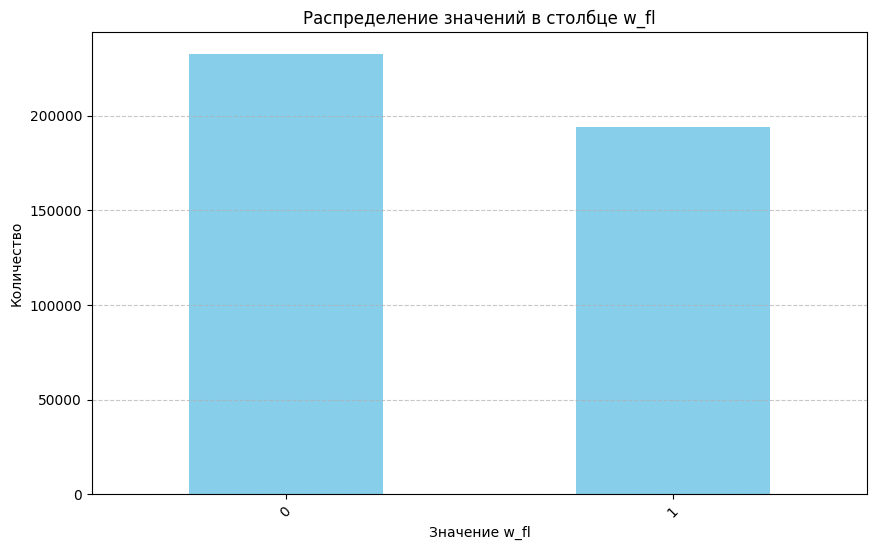

In [38]:
import matplotlib.pyplot as plt

w_fl_counts = data_cleaned['w_fl'].value_counts()

plt.figure(figsize=(10, 6))
w_fl_counts.plot(kind='bar', color='skyblue')
plt.title('Распределение значений в столбце w_fl')
plt.xlabel('Значение w_fl')
plt.ylabel('Количество')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

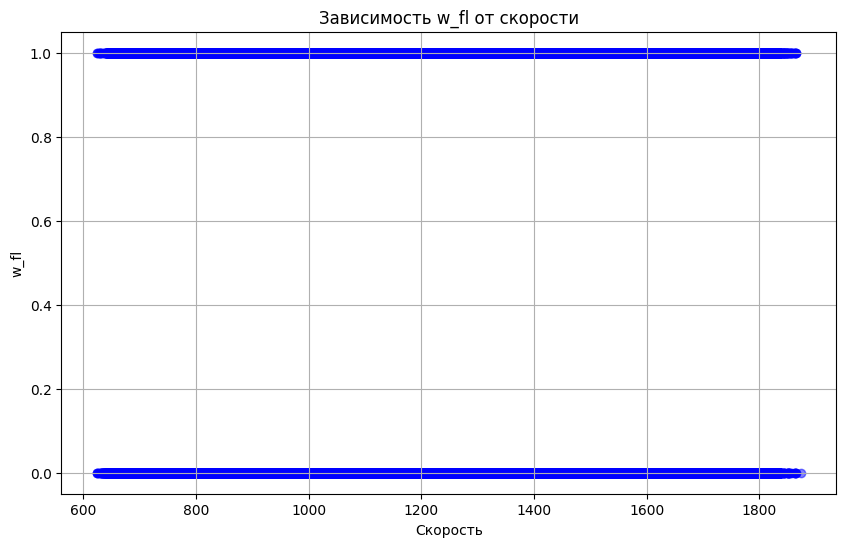

In [68]:
plt.figure(figsize=(10, 6))
plt.scatter(data_cleaned['engine_speed'], data_cleaned['w_fl'], alpha=0.5, color='blue')
plt.title('Зависимость w_fl от скорости')
plt.xlabel('Скорость')
plt.ylabel('w_fl')
plt.grid(True)
plt.show()

In [133]:
data_cleaned = data_cleaned[data_cleaned['engine_speed'] >= 500]

In [70]:
data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 414171 entries, 0 to 426321
Data columns (total 19 columns):
 #   Column                Non-Null Count   Dtype                                
---  ------                --------------   -----                                
 0   objectid              414171 non-null  int64                                
 1   time                  414171 non-null  datetime64[ns, pytz.FixedOffset(420)]
 2   lat                   414171 non-null  float64                              
 3   lon                   414171 non-null  float64                              
 4   speed                 414171 non-null  float64                              
 5   height                414171 non-null  float64                              
 6   fuel_cons             414171 non-null  float64                              
 7   engine_speed          414171 non-null  float64                              
 8   hdop                  414171 non-null  float64                  

In [77]:
#Можно предположить что w_fl зависит от fuel_cons или weight_dynamic, потому что коэфицент корреляции между этими
#столбцами наивысший. Если от weight_dynamic, то возможно он показывает в определенный момент времени есть ли перегруз
#либо что-то еще связанное с весом

## Задание 2

Все пункты делаются на данных, оставшихся после чистки в Задании 1. Правильных ответов (по числам) нет, т к препроцессинг может отличаться. Нам интересно увидеть, как Вы это делаете.
* Вывести средние значения параметров ['hdop', 'speed', 'engine_speed', 'DQ_vertical_bump', 'height'] по самосвалам
* Построить гистограмму суммарных расстояний за каждый рейс.
* Вывести таблицу средних скоростей самосвалов за каждый час суток (формат: колонки - час суток, строки - самосвалы, в ячейках - средняя скорость)
* Выбрать по одному рейсу для каждого самосвала. Для каждого рейса: нарисовать его на общей карте карьера, нарисовать на одном графике кривую изменения скорости от времени и высоты от времени (шкалы должны быть на разных осях).
* Присоединить данные погоды к данным телеметрии

In [83]:
data_cleaned['DQ_vertical_bump'].unique()

array([0], dtype=int64)

In [81]:
data_cleaned['objectid'].unique()

array([1121, 1124, 1126, 1125, 1123, 1122], dtype=int64)

In [80]:
mean_values = data_cleaned.groupby('objectid')[['hdop', 'speed', 'engine_speed', 'DQ_vertical_bump', 'height']].mean()

mean_values

,hdop,speed,engine_speed,DQ_vertical_bump,height
objectid,,,,,
1121,92.918064,9.921136,1214.000000,0.0,62.150815
1122,99.990000,0.014295,1214.000000,0.0,236.917898
1123,2.465518,16.343266,1214.000000,0.0,90.712864
1124,7.038113,12.791139,1135.724449,0.0,266.990266
1125,8.516213,13.257937,1164.304336,0.0,264.321223
1126,7.584820,13.430823,1161.572864,0.0,262.754274


In [91]:
data_cleaned['time'] = pd.to_datetime(data_cleaned['time'])

data_cleaned['hour'] = data_cleaned['time'].dt.hour

average_speeds = data_cleaned.groupby(['hour', 'objectid'])['speed'].mean()

average_speeds_table = average_speeds.unstack(level=0)
average_speeds_table

hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
objectid,,,,,,,,,,,,,,,,,,,,,
1121,18.466040,12.862556,8.235196,6.410654,13.865112,5.952499,7.554358,4.958597,7.181664,11.518727,...,6.155436,14.149674,9.615145,8.214560,13.732471,9.268503,9.241412,11.137591,8.723652,5.201494
1122,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.032650,0.001737,NaN,NaN
1123,22.358631,18.714639,21.400921,11.881461,21.848800,15.330034,9.890281,11.867700,16.240954,15.558113,...,21.100563,17.448561,21.084696,11.919764,17.851139,8.152207,12.966198,15.429917,13.583356,4.830119
1124,19.360650,15.550194,17.290861,10.585278,14.064222,12.226444,14.285306,5.915778,11.248639,12.159278,...,11.643333,8.631111,9.319694,13.571139,13.014444,7.291333,19.083028,20.814111,15.509917,16.904917
1125,0.000000,NaN,NaN,15.981186,17.857639,15.306083,13.476444,11.308389,13.151722,12.256889,...,11.587000,9.888028,13.990139,13.970139,13.657278,6.873750,16.893639,20.637611,17.667306,14.406250
1126,17.664315,18.087889,15.322750,12.422889,17.381333,15.643083,14.816139,6.677806,13.042917,12.466944,...,11.875417,6.552028,14.732750,12.356639,12.940250,8.752861,17.955361,20.612500,15.397639,15.169694


In [95]:
one_trip_per_truck = data_cleaned.groupby('objectid').first().reset_index()
one_trip_per_truck

,objectid,time,lat,lon,speed,height,fuel_cons,engine_speed,hdop,DQ_vertical_bump,...,fuel_tank_level,weight_dynamic,tripid,weight,driverid,w_fl,x,y,distance,hour
0,1121,2023-11-08 05:31:31.309000+07:00,63.328824,83.727988,3.003940,195.7,390.00,1214.0,99.99,0,...,60.0,216.0,1003671.0,215.0,2891.0,1,636592.202274,7.025133e+06,None,5
1,1122,2023-11-08 20:59:39.486000+07:00,63.303024,83.751988,0.001852,236.9,28.00,1214.0,99.99,0,...,26.0,0.0,1003732.0,212.0,2875.0,0,637916.728420,7.022312e+06,None,20
2,1123,2023-11-08 09:09:34.730000+07:00,63.342024,83.703988,13.232500,28.9,2.00,1214.0,0.87,0,...,68.0,219.0,1003705.0,219.0,2878.0,1,635329.007337,7.026552e+06,None,9
3,1124,2023-11-08 19:20:55+07:00,63.343592,83.739678,4.200000,228.0,66.85,778.0,5.00,0,...,60.0,216.0,1003798.0,217.0,2875.0,0,637106.943106,7.026803e+06,None,19
4,1125,2023-11-08 05:34:15+07:00,63.336234,83.748103,19.800000,260.0,206.90,1465.0,8.00,0,...,38.0,0.0,1003674.0,211.0,2887.0,1,637563.523399,7.026001e+06,None,5
5,1126,2023-11-08 04:07:24+07:00,63.336267,83.747848,22.500000,277.0,170.65,1428.0,7.00,0,...,38.0,0.0,1003662.0,210.0,2907.0,1,637550.606949,7.026004e+06,None,4


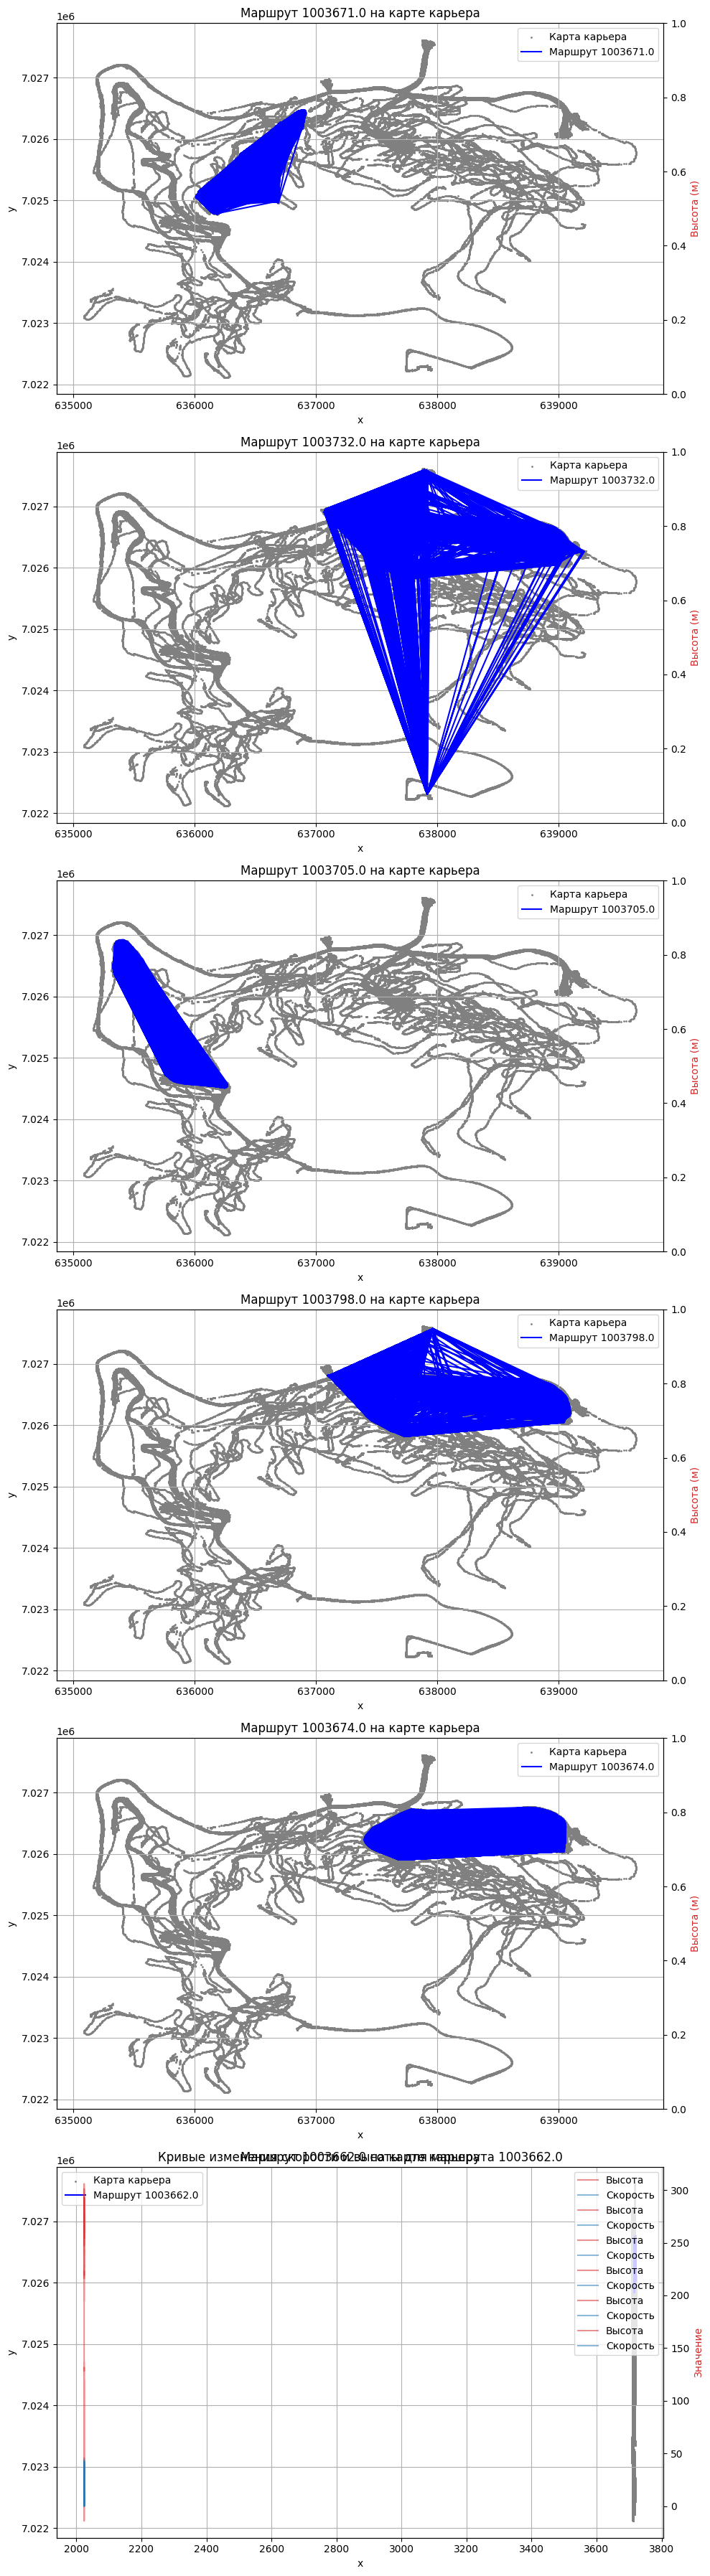

In [97]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=len(one_trip_per_truck), ncols=1, figsize=(10, 6 * len(one_trip_per_truck)))

for ax in axes:
    ax2 = ax.twinx()
    ax2.set_ylabel('Высота (м)', color='tab:red')

for i, row in one_trip_per_truck.iterrows():
    trip_data = data_cleaned[data_cleaned['tripid'] == row['tripid']]
    
    axes[i].scatter(data_cleaned['x'], data_cleaned['y'], color='gray', s=1, label='Карта карьера')
    axes[i].plot(trip_data['x'], trip_data['y'], label=f'Маршрут {row["tripid"]}', color='blue')
    axes[i].set_xlabel('x')
    axes[i].set_ylabel('y')
    axes[i].set_title(f'Маршрут {row["tripid"]} на карте карьера')
    axes[i].legend()
    axes[i].grid(True)

    ax2.plot(trip_data['time'], trip_data['height'], label='Высота', color='tab:red', alpha=0.5)
    ax2.plot(trip_data['time'], trip_data['speed'], label='Скорость', color='tab:blue', alpha=0.5)
    ax2.set_ylabel('Значение')
    ax2.set_title(f'Кривые изменения скорости и высоты для маршрута {row["tripid"]}')
    ax2.legend()

plt.tight_layout()
plt.show()


In [134]:
data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 414171 entries, 0 to 426321
Data columns (total 19 columns):
 #   Column                Non-Null Count   Dtype                                
---  ------                --------------   -----                                
 0   objectid              414171 non-null  int64                                
 1   time                  414171 non-null  datetime64[ns, pytz.FixedOffset(420)]
 2   lat                   414171 non-null  float64                              
 3   lon                   414171 non-null  float64                              
 4   speed                 414171 non-null  float64                              
 5   height                414171 non-null  float64                              
 6   fuel_cons             414171 non-null  float64                              
 7   engine_speed          414171 non-null  float64                              
 8   hdop                  414171 non-null  float64                  

In [108]:
data_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55 entries, 0 to 54
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype              
---  ------               --------------  -----              
 0   time                 55 non-null     datetime64[ns, UTC]
 1   precipIntensity      55 non-null     float64            
 2   precipProbability    55 non-null     float64            
 3   temperature          55 non-null     float64            
 4   apparentTemperature  55 non-null     float64            
 5   dewPoint             55 non-null     float64            
 6   humidity             55 non-null     float64            
 7   pressure             55 non-null     float64            
 8   windSpeed            55 non-null     float64            
 9   windGust             55 non-null     float64            
 10  windBearing          55 non-null     float64            
 11  cloudCover           55 non-null     float64            
 12  visibility           55 

In [135]:
data_cleaned['time'] = data_cleaned['time'].dt.tz_convert('UTC')
data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 414171 entries, 0 to 426321
Data columns (total 19 columns):
 #   Column                Non-Null Count   Dtype              
---  ------                --------------   -----              
 0   objectid              414171 non-null  int64              
 1   time                  414171 non-null  datetime64[ns, UTC]
 2   lat                   414171 non-null  float64            
 3   lon                   414171 non-null  float64            
 4   speed                 414171 non-null  float64            
 5   height                414171 non-null  float64            
 6   fuel_cons             414171 non-null  float64            
 7   engine_speed          414171 non-null  float64            
 8   hdop                  414171 non-null  float64            
 9   DQ_vertical_bump      414171 non-null  int64              
 10  accelerator_position  414171 non-null  int64              
 11  fuel_tank_level       414171 non-null  float64      

In [136]:
data_cleaned

,objectid,time,lat,lon,speed,height,fuel_cons,engine_speed,hdop,DQ_vertical_bump,accelerator_position,fuel_tank_level,weight_dynamic,tripid,weight,driverid,w_fl,x,y
0,1121,2023-11-07 22:31:31.309000+00:00,63.328824,83.727988,3.003940,195.7,390.00,1177.000,99.99,0,0,60.0,216.0,1003671.0,215.0,2891.0,1,636592.202274,7.025133e+06
2,1124,2023-11-08 12:20:55+00:00,63.343592,83.739678,4.200000,228.0,66.85,778.000,5.00,0,0,60.0,216.0,1003798.0,217.0,2875.0,0,637106.943106,7.026803e+06
3,1124,2023-11-08 07:16:39+00:00,63.343290,83.751773,16.800000,278.0,2.45,743.375,6.00,0,0,60.0,216.0,1003749.0,209.0,2875.0,0,637713.403209,7.026795e+06
4,1121,2023-11-08 04:09:49.347000+00:00,63.331924,83.765388,0.000000,70.9,17.00,1177.000,99.99,0,0,38.0,0.0,1003728.0,204.0,2894.0,0,638449.084136,7.025559e+06
5,1121,2023-11-08 04:07:48.346000+00:00,63.331924,83.765388,0.009260,70.5,2.00,1177.000,99.99,0,0,38.0,0.0,1003728.0,204.0,2894.0,0,638449.084136,7.025559e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426315,1125,2023-11-08 02:27:38+00:00,63.334804,83.750968,0.100000,247.0,15.30,1128.750,6.00,0,0,58.0,1.0,1003710.0,206.0,2889.0,0,637713.709827,7.025848e+06
426316,1125,2023-11-08 13:40:23+00:00,63.338977,83.780301,3.100000,291.0,212.30,1347.500,9.00,0,0,58.0,1.0,1003805.0,213.0,2889.0,1,639161.272514,7.026376e+06
426317,1124,2023-11-08 07:24:19+00:00,63.335549,83.750929,0.300000,266.0,28.30,1125.625,6.00,0,0,58.0,1.0,1003749.0,209.0,2875.0,0,637708.196440,7.025931e+06
426318,1123,2023-11-08 16:18:10.761000+00:00,63.322124,83.718488,0.001852,139.8,14.00,1177.000,1.04,0,0,97.0,0.0,1003841.0,203.0,2878.0,0,636148.397412,7.024367e+06


In [137]:
data_cleaned['time'] = data_cleaned['time'].dt.floor('H')
data_cleaned

,objectid,time,lat,lon,speed,height,fuel_cons,engine_speed,hdop,DQ_vertical_bump,accelerator_position,fuel_tank_level,weight_dynamic,tripid,weight,driverid,w_fl,x,y
0,1121,2023-11-07 22:00:00+00:00,63.328824,83.727988,3.003940,195.7,390.00,1177.000,99.99,0,0,60.0,216.0,1003671.0,215.0,2891.0,1,636592.202274,7.025133e+06
2,1124,2023-11-08 12:00:00+00:00,63.343592,83.739678,4.200000,228.0,66.85,778.000,5.00,0,0,60.0,216.0,1003798.0,217.0,2875.0,0,637106.943106,7.026803e+06
3,1124,2023-11-08 07:00:00+00:00,63.343290,83.751773,16.800000,278.0,2.45,743.375,6.00,0,0,60.0,216.0,1003749.0,209.0,2875.0,0,637713.403209,7.026795e+06
4,1121,2023-11-08 04:00:00+00:00,63.331924,83.765388,0.000000,70.9,17.00,1177.000,99.99,0,0,38.0,0.0,1003728.0,204.0,2894.0,0,638449.084136,7.025559e+06
5,1121,2023-11-08 04:00:00+00:00,63.331924,83.765388,0.009260,70.5,2.00,1177.000,99.99,0,0,38.0,0.0,1003728.0,204.0,2894.0,0,638449.084136,7.025559e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426315,1125,2023-11-08 02:00:00+00:00,63.334804,83.750968,0.100000,247.0,15.30,1128.750,6.00,0,0,58.0,1.0,1003710.0,206.0,2889.0,0,637713.709827,7.025848e+06
426316,1125,2023-11-08 13:00:00+00:00,63.338977,83.780301,3.100000,291.0,212.30,1347.500,9.00,0,0,58.0,1.0,1003805.0,213.0,2889.0,1,639161.272514,7.026376e+06
426317,1124,2023-11-08 07:00:00+00:00,63.335549,83.750929,0.300000,266.0,28.30,1125.625,6.00,0,0,58.0,1.0,1003749.0,209.0,2875.0,0,637708.196440,7.025931e+06
426318,1123,2023-11-08 16:00:00+00:00,63.322124,83.718488,0.001852,139.8,14.00,1177.000,1.04,0,0,97.0,0.0,1003841.0,203.0,2878.0,0,636148.397412,7.024367e+06


In [138]:
merged_data = pd.merge(data_cleaned, data_weather, on='time', how='left')
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 414171 entries, 0 to 414170
Data columns (total 35 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   objectid              414171 non-null  int64  
 1   time                  414171 non-null  object 
 2   lat                   414171 non-null  float64
 3   lon                   414171 non-null  float64
 4   speed                 414171 non-null  float64
 5   height                414171 non-null  float64
 6   fuel_cons             414171 non-null  float64
 7   engine_speed          414171 non-null  float64
 8   hdop                  414171 non-null  float64
 9   DQ_vertical_bump      414171 non-null  int64  
 10  accelerator_position  414171 non-null  int64  
 11  fuel_tank_level       414171 non-null  float64
 12  weight_dynamic        414171 non-null  float64
 13  tripid                414171 non-null  float64
 14  weight                414171 non-null  float64
 15  

## Задание 3

**Обучить модель для предсказания значений скорости самосвала (колонка speed)**
* Можно (и даже нужно) генерировать дополнительные фичи.
* Выполнить необходимые (на Ваш взгляд) преобразования датасета.
* Выбрать метрику(и) для оценки качества модели, объяснить причину выбора данной метрики
* Обучить несколько моделей и сравнить их. Интерпретировать результаты.

In [139]:
merged_data.head(10)

,objectid,time,lat,lon,speed,height,fuel_cons,engine_speed,hdop,DQ_vertical_bump,...,pressure,windSpeed,windGust,windBearing,cloudCover,visibility,precipType,rain,snow,no_weather_info
0,1121,2023-11-07 22:00:00+00:00,63.328824,83.727988,3.003940,195.7,390.00,1177.000,99.99,0,...,1026.0,3.68,9.31,66.0,100.0,10000.0,clouds,0,0,1
1,1124,2023-11-08 12:00:00+00:00,63.343592,83.739678,4.200000,228.0,66.85,778.000,5.00,0,...,1019.0,2.86,5.81,75.0,100.0,10000.0,clouds,0,0,1
2,1124,2023-11-08 07:00:00+00:00,63.343290,83.751773,16.800000,278.0,2.45,743.375,6.00,0,...,1020.0,3.62,6.70,74.0,100.0,10000.0,clouds,0,0,1
3,1121,2023-11-08 04:00:00+00:00,63.331924,83.765388,0.000000,70.9,17.00,1177.000,99.99,0,...,1022.0,3.94,8.91,71.0,100.0,10000.0,clouds,0,0,1
4,1121,2023-11-08 04:00:00+00:00,63.331924,83.765388,0.009260,70.5,2.00,1177.000,99.99,0,...,1022.0,3.94,8.91,71.0,100.0,10000.0,clouds,0,0,1
5,1126,2023-11-07 21:00:00+00:00,63.336267,83.747848,22.500000,277.0,170.65,1428.000,7.00,0,...,1027.0,3.69,9.11,61.0,100.0,10000.0,clouds,0,0,1
6,1124,2023-11-07 18:00:00+00:00,63.340780,83.748519,22.200000,281.0,176.45,1394.250,8.00,0,...,1028.0,3.55,8.92,62.0,95.0,10000.0,clouds,0,0,1
7,1125,2023-11-07 22:00:00+00:00,63.336234,83.748103,19.800000,260.0,206.90,1465.000,8.00,0,...,1026.0,3.68,9.31,66.0,100.0,10000.0,clouds,0,0,1
8,1123,2023-11-08 02:00:00+00:00,63.342024,83.703988,13.232500,28.9,2.00,1177.000,0.87,0,...,1023.0,3.93,9.61,65.0,100.0,10000.0,clouds,0,0,1
9,1123,2023-11-08 12:00:00+00:00,63.321924,83.718788,0.001852,157.2,25.00,1177.000,0.90,0,...,1019.0,2.86,5.81,75.0,100.0,10000.0,clouds,0,0,1


In [148]:
data_norm['rain'].unique()

array([0], dtype=int64)

In [156]:
data_norm['no_weather_info'].unique()

array([1], dtype=int64)

In [157]:
data_norm = merged_data.drop(['time', 'DQ_vertical_bump', 'accelerator_position', 'rain', 'objectid', 'no_weather_info'], axis=1)

In [147]:
data_norm['snow'].unique()

array([0, 1], dtype=int64)

In [150]:
data_norm['precipType'].unique()

array(['clouds', 'snow'], dtype=object)

In [151]:
data_norm['visibility'].unique()

array([10000.,  9169.])

In [158]:
data_norm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 414171 entries, 0 to 414170
Data columns (total 29 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   lat                  414171 non-null  float64
 1   lon                  414171 non-null  float64
 2   speed                414171 non-null  float64
 3   height               414171 non-null  float64
 4   fuel_cons            414171 non-null  float64
 5   engine_speed         414171 non-null  float64
 6   hdop                 414171 non-null  float64
 7   fuel_tank_level      414171 non-null  float64
 8   weight_dynamic       414171 non-null  float64
 9   tripid               414171 non-null  float64
 10  weight               414171 non-null  float64
 11  driverid             414171 non-null  float64
 12  w_fl                 414171 non-null  int64  
 13  x                    414171 non-null  float64
 14  y                    414171 non-null  float64
 15  precipIntensity  

In [161]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

data_norm['precipType'] = label_encoder.fit_transform(data_norm['precipType'])

In [170]:
data_norm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 414171 entries, 0 to 414170
Data columns (total 29 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   lat                  414171 non-null  float64
 1   lon                  414171 non-null  float64
 2   speed                414171 non-null  float64
 3   height               414171 non-null  float64
 4   fuel_cons            414171 non-null  float64
 5   engine_speed         414171 non-null  float64
 6   hdop                 414171 non-null  float64
 7   fuel_tank_level      414171 non-null  float64
 8   weight_dynamic       414171 non-null  float64
 9   tripid               414171 non-null  float64
 10  weight               414171 non-null  float64
 11  driverid             414171 non-null  float64
 12  w_fl                 414171 non-null  int64  
 13  x                    414171 non-null  float64
 14  y                    414171 non-null  float64
 15  precipIntensity  

In [173]:
data_norm['temperature_dewPoint_diff'] = data_norm['temperature'] - data_norm['dewPoint']
data_norm['fuel_cons_engine_speed_product'] = data_norm['fuel_cons'] * data_norm['engine_speed']
data_norm

,lat,lon,speed,height,fuel_cons,engine_speed,hdop,fuel_tank_level,weight_dynamic,tripid,...,pressure,windSpeed,windGust,windBearing,cloudCover,visibility,precipType,snow,temperature_dewPoint_diff,fuel_cons_engine_speed_product
0,63.328824,83.727988,3.003940,195.7,390.00,1177.000,99.99,60.0,216.0,1003671.0,...,1026.0,3.68,9.31,66.0,100.0,10000.0,0,0,4.81,459030.00000
1,63.343592,83.739678,4.200000,228.0,66.85,778.000,5.00,60.0,216.0,1003798.0,...,1019.0,2.86,5.81,75.0,100.0,10000.0,0,0,5.17,52009.30000
2,63.343290,83.751773,16.800000,278.0,2.45,743.375,6.00,60.0,216.0,1003749.0,...,1020.0,3.62,6.70,74.0,100.0,10000.0,0,0,7.05,1821.26875
3,63.331924,83.765388,0.000000,70.9,17.00,1177.000,99.99,38.0,0.0,1003728.0,...,1022.0,3.94,8.91,71.0,100.0,10000.0,0,0,5.75,20009.00000
4,63.331924,83.765388,0.009260,70.5,2.00,1177.000,99.99,38.0,0.0,1003728.0,...,1022.0,3.94,8.91,71.0,100.0,10000.0,0,0,5.75,2354.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
414166,63.334804,83.750968,0.100000,247.0,15.30,1128.750,6.00,58.0,1.0,1003710.0,...,1023.0,3.93,9.61,65.0,100.0,10000.0,0,0,5.18,17269.87500
414167,63.338977,83.780301,3.100000,291.0,212.30,1347.500,9.00,58.0,1.0,1003805.0,...,1019.0,2.71,5.73,79.0,100.0,10000.0,0,0,5.00,286074.25000
414168,63.335549,83.750929,0.300000,266.0,28.30,1125.625,6.00,58.0,1.0,1003749.0,...,1020.0,3.62,6.70,74.0,100.0,10000.0,0,0,7.05,31855.18750
414169,63.322124,83.718488,0.001852,139.8,14.00,1177.000,1.04,97.0,0.0,1003841.0,...,1018.0,1.73,5.51,94.0,100.0,9169.0,0,0,3.72,16478.00000


In [174]:
data_norm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 414171 entries, 0 to 414170
Data columns (total 31 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   lat                             414171 non-null  float64
 1   lon                             414171 non-null  float64
 2   speed                           414171 non-null  float64
 3   height                          414171 non-null  float64
 4   fuel_cons                       414171 non-null  float64
 5   engine_speed                    414171 non-null  float64
 6   hdop                            414171 non-null  float64
 7   fuel_tank_level                 414171 non-null  float64
 8   weight_dynamic                  414171 non-null  float64
 9   tripid                          414171 non-null  float64
 10  weight                          414171 non-null  float64
 11  driverid                        414171 non-null  float64
 12  w_fl            

In [177]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

X = data_norm.drop('speed',axis=1)
y = data_norm['speed']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#Будет выбрана метрика mae, так как у нас задача регрессии, а самая понятная и удобная метрика для бизнеса это mae, так как
#показывает абсолютную ошибку

In [183]:
from sklearn.metrics import mean_absolute_error

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error:", mae)

Mean Absolute Error: 9.659782826413734


In [181]:
y.mean()

13.092248720885811

In [185]:
from xgboost import XGBRegressor

model_xgb = XGBRegressor(random_state=42)
model_xgb.fit(X_train, y_train)

y_pred = model_xgb.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error (MAE):", mae)

Mean Absolute Error (MAE): 2.2158937331128397


In [189]:
from catboost import CatBoostRegressor

catboost_model = CatBoostRegressor(iterations=1000, learning_rate=0.1, depth=6, random_state=42, verbose=0)
catboost_model.fit(X_train, y_train)

y_pred = catboost_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error:", mae)

Mean Absolute Error: 2.2317830164297727


In [190]:
from catboost import CatBoostRegressor

catboost_model = CatBoostRegressor(iterations=1000, learning_rate=0.1, depth=8, random_state=42, verbose=0)
catboost_model.fit(X_train, y_train)

y_pred = catboost_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error:", mae)

Mean Absolute Error: 1.8645131874614005


In [192]:
y_train_pred = catboost_model.predict(X_train)
mae_train = mean_absolute_error(y_train, y_train_pred)
print("MAE на обучающем наборе:", mae_train)
#Выполнена проверка не переобучение

MAE на обучающем наборе: 1.808561713263042


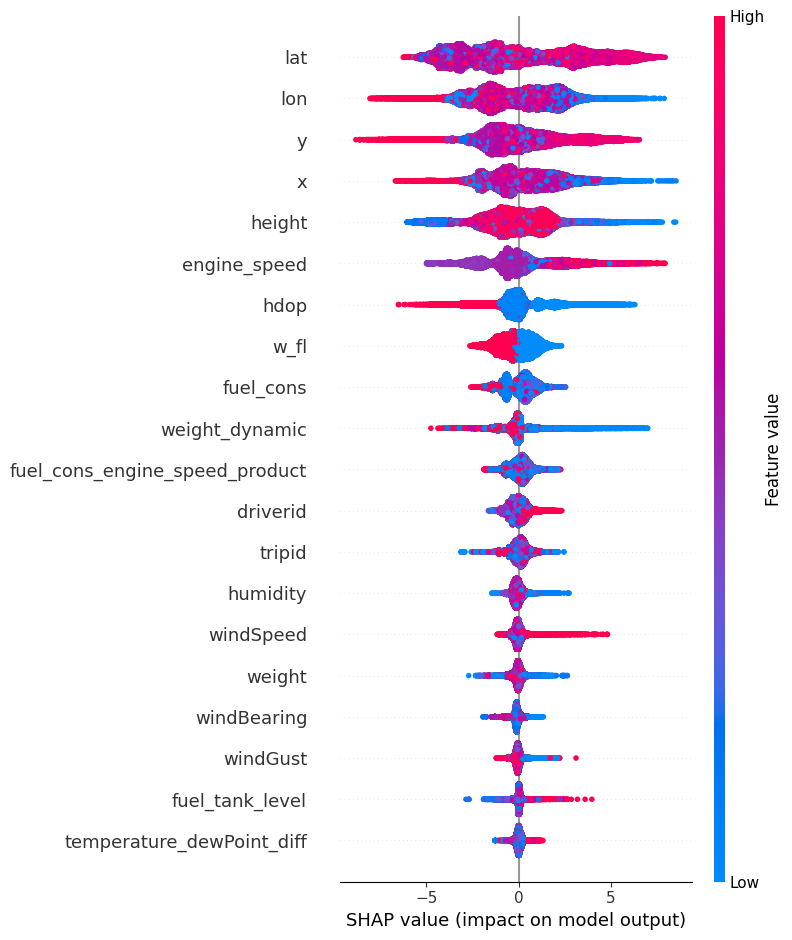

In [193]:
import shap

feature_importance = catboost_model.feature_importances_

explainer = shap.TreeExplainer(catboost_model)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test)

In [194]:
sample_indices = [0, 1, 2]
shap_values_samples = explainer.shap_values(X_test.iloc[sample_indices])

shap.initjs()
shap.force_plot(explainer.expected_value, shap_values_samples, X_test.iloc[sample_indices])